**Class Activation Maps**

CAM is a technique that provides insight into which parts of an image are important for a model's prediction. It visualizes class-specific regions in an image, highlighting the areas that contribute the most to the final decision of a classification model.

In [27]:
import os
from torch_snippets import *
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 659M/675M [00:13<00:00, 72.1MB/s]
100% 675M/675M [00:13<00:00, 53.8MB/s]


In [18]:
!unzip -qq cell-images-for-detecting-malaria.zip

In [19]:
!rm cell-images-for-detecting-malaria.zip

**Specify the indeces corresponding to the output classes**

In [22]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

**Transformations on top of the input image**

In [24]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05),
                  contrast=(0.95,1.05),
                  saturation=(0.95,1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [42]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

**Dataset Class**

In [43]:
class MalariaImages(Dataset):
  def __init__(self, files, transform=None):
    self.files = files
    self.transform = transform
    logger.info(len(self))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, ix):
    fpath = self.files[ix]
    clss = fname(parent(fpath))
    img = read(fpath, 1)
    return img, clss

  def choose(self):
    return self[randint(len(self))]

  def collate_fn(self, batch):
    _imgs, classes = list(zip(*batch))
    if self.transform:
      imgs = [self.transform(img)[None] for img in _imgs]
    classes = [torch.tensor([id2int[clss]]) for clss in classes]
    imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    return imgs, classes, _imgs

**Fetch the training datasets and dataloaders**

In [44]:
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

[08/16/24 04:49:53] INFO     20668                                                                                                ]8;id=150006;file://<ipython-input-43-7a086debb904>:5\<ipython-input-43-7a086debb904>]8;;\:]8;id=297192;file://<ipython-input-43-7a086debb904>:5#__init__:5\__init__:5]8;;\

                    INFO     6890                                                                                                 ]8;id=524291;file://<ipython-input-43-7a086debb904>:5\<ipython-input-43-7a086debb904>]8;;\:]8;id=33671;file://<ipython-input-43-7a086debb904>:5#__init__:5\__init__:5]8;;\

In [45]:
print(f'All Images: {len(all_files)}, Train Images: {len(trn_ds)}, Validation Images: {len(val_ds)}')

All Images: 27558, Train Images: 20668, Validation Images: 6890


**Model Architecture**

In [46]:
def convBlock(ni, no):
  return nn.Sequential(
      nn.Dropout(0.2),
      nn.Conv2d(ni, no, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2),
  )

class MalariaClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        convBlock(3, 64),
        convBlock(64, 64),
        convBlock(64, 128),
        convBlock(128, 256),
        convBlock(256, 512),
        convBlock(512, 64),
        nn.Flatten(),
        nn.Linear(256, 256),
        nn.Dropout(0.2),
        nn.ReLU(inplace=True),
        nn.Linear(256, len(id2int))
    )
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, x):
    return self.model(x)
  def compute_metrics(self, preds, targets):
    loss = self.loss_fn(preds, targets)
    acc = (torch.max(preds, 1)[1]==targets).float().mean()
    return loss, acc

**Functions to train and validate on batch data**

In [47]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

**Model Training**

In [54]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  trn_acc: 0.906  trn_loss: 0.244  val_loss: 0.170  val_acc: 0.949  (149.38s - 597.53s remaining)
EPOCH: 2.000  trn_acc: 0.945  trn_loss: 0.170  val_loss: 0.170  val_acc: 0.946  (287.41s - 431.11s remaining)
EPOCH: 3.000  trn_acc: 0.947  trn_loss: 0.162  val_loss: 0.173  val_acc: 0.950  (423.21s - 282.14s remaining)
EPOCH: 4.000  trn_acc: 0.949  trn_loss: 0.154  val_loss: 0.151  val_acc: 0.952  (557.12s - 139.28s remaining)
EPOCH: 5.000  trn_acc: 0.950  trn_loss: 0.150  val_loss: 0.151  val_acc: 0.954  (692.38s - 0.00s remaining)


**Save Model weights**

In [55]:
torch.save(model.state_dict(), 'model_weights.pth')

**Fetch the convolution layer in the fifth `convBlock` in the model.**

In [56]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [57]:
im2fmap

Sequential(
  (0): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

**im2gradCAM**

takes an input image and fetches the
heatmap corresponding to activations of the image



In [58]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [59]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


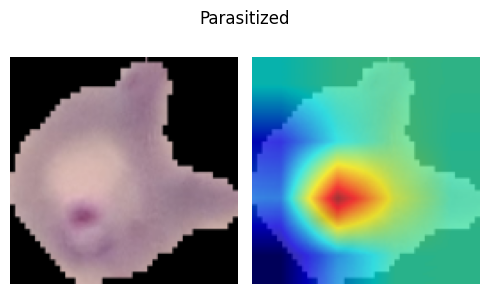

torch.Size([1, 64, 4, 4])


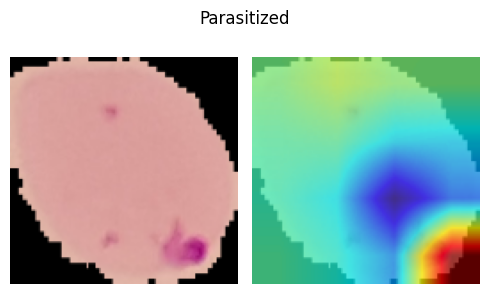

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


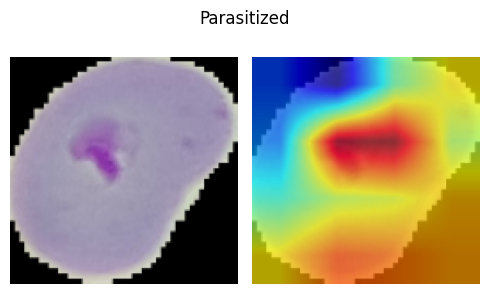

torch.Size([1, 64, 4, 4])


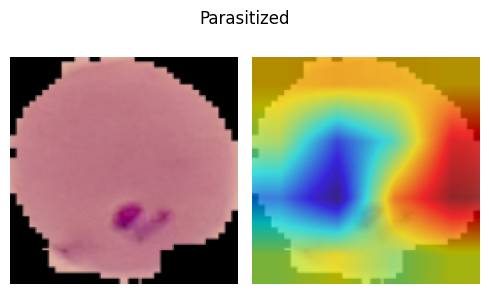

torch.Size([1, 64, 4, 4])


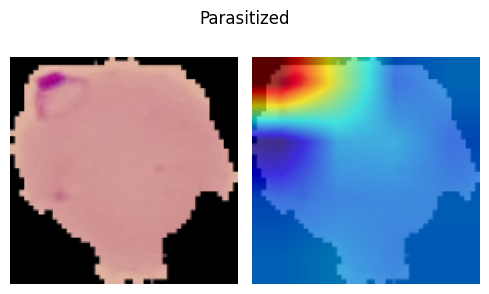

torch.Size([1, 64, 4, 4])


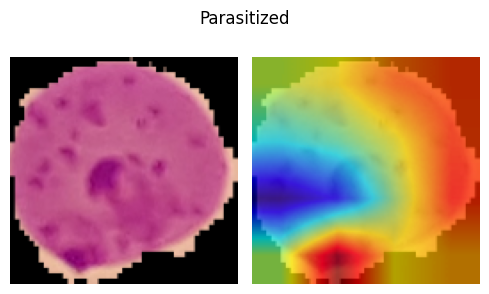

torch.Size([1, 64, 4, 4])


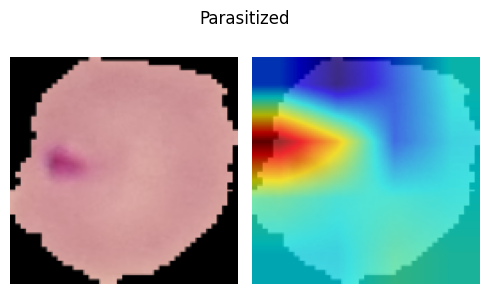

torch.Size([1, 64, 4, 4])


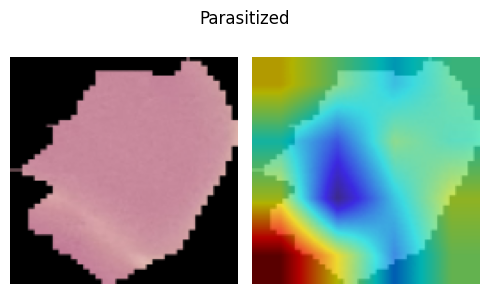

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


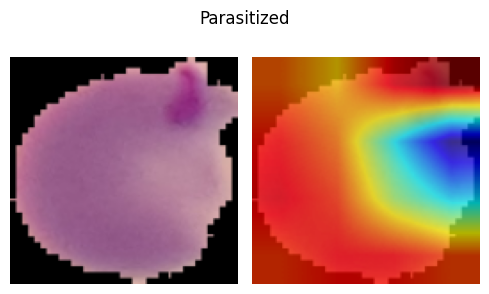

torch.Size([1, 64, 4, 4])


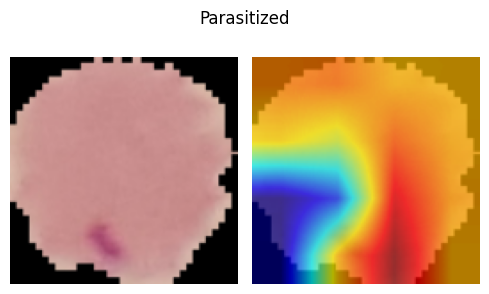

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


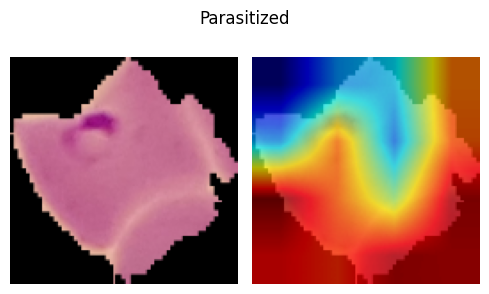

torch.Size([1, 64, 4, 4])


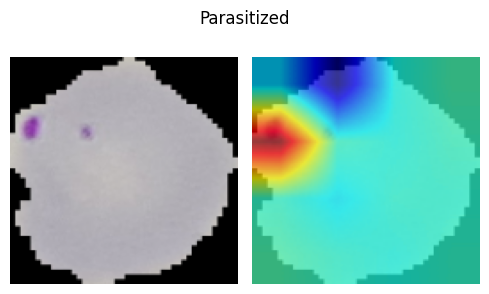

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


In [60]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn = val_ds.collate_fn)
x, y, z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)
